In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls '/content/drive/My Drive/Colab Notebooks'

Mounted at /content/drive
'Algorithm 01'			        modified.csv
'Algorithm 02.ipynb'		        naver_map_data_live.csv
'Algorithm 03.ipynb'		       'naver_map_data_live_modified (2).csv'
 BreamAndSmelt.ipynb		        preprocessed_data.csv
 Chapter2			        processed_data.csv
'Chapter 3'			        processed_data_menu.csv
'Chapter 3-2 Linear Regression.ipynb'   processed_naver_map_data.csv
'Chapter 3-3 Feature Engineering'       processed_store_data.csv
'cleaned_data (1).csv'		        rating_median_filled.csv
 cleaned_data.csv		        rating_taste_updated.csv
'Copy of whisper-webui.ipynb'	        recrawl1.csv
 data_a.csv			        recrawl2.csv
 distance_applied.csv		        recrawl3.csv
 dontletthemknow.csv		        recrawl4.csv
 final_data_1.csv		        recrawl_data_1.csv
 final_data_2_1.csv		        recrawl_data_2.csv
 final_data_2.csv		        ReCrawl.ipynb
 final_data_3.csv		        re_crawl_menues.py
 final_data.csv			        RecrawlModeling.ipynb
 KHUDA.ipynb			        review_me

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

X_check = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final_data_2_1.csv')

#One-hot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
X_check['category_o'] = label_encoder.fit_transform(X_check['category'])
#Scaling
scaler = MinMaxScaler(feature_range=(1,5))
X_check['rating'] = scaler.fit_transform(X_check[['rating']])
X_check['y'] =  scaler.fit_transform(X_check[['y']])
#두번째 크롤링한 데이터 가져오기
new_values = pd.read_csv('/content/drive/My Drive/Colab Notebooks/recrawl2.csv')
new_values = new_values.drop_duplicates(subset=['store_name'])

#새로운 taste_value를 사용하지 않게 되어서 주석 처리함 (사용하려면 기존의 taste_value 이름을 바꿔야해서 깔끔하게 하려고)
#X_check.rename(columns={'taste_value':'old_taste_value'},inplace=True)
#X_check = pd.merge(X_check,new_values,on='store_name',how='left')
X_check.drop_duplicates(subset=['store_name'])

#불필요한 컬럼 제거
X_check.drop(columns=['menu1_price','menu2_price','menu3_price','target_a','target_b','target_c','target_d'],inplace=True)

#데이터 확인
X_check.describe()

,rating,taste_value,distance,category_group,visited_review,blog_review,visited_review_log,blog_review_log,average_price,y,category_o
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000
mean,3.528099,0.343848,0.837745,3.269784,659.147482,282.176259,5.917327,4.933241,21398.561151,2.949640,36.823741
std,0.453984,0.122027,0.308039,2.267942,827.767069,418.971563,1.105753,1.189659,26124.799374,0.804900,18.630200
min,1.000000,0.014000,0.142000,1.000000,14.000000,4.000000,2.708050,1.609438,3000.000000,1.000000,0.000000
25%,3.347826,0.277225,0.673000,1.000000,184.500000,62.000000,5.223044,4.143135,10000.000000,2.500000,21.250000
50%,3.463768,0.333550,0.885500,3.000000,374.500000,130.500000,5.928236,4.879000,16000.000000,3.285714,40.000000
75%,3.753623,0.416750,0.979250,6.000000,764.000000,273.250000,6.639866,5.614029,23375.000000,3.285714,54.000000
max,5.000000,0.784000,2.100000,7.000000,5964.000000,2844.000000,8.693664,7.953318,275000.000000,5.000000,65.000000


In [ ]:
#특성 엔지니어링 (각주는 버려진 특성임)
X_check['taste_value_reviews'] = (X_check['taste_value'])* (X_check['visited_review_log'])
X_check['distance_price'] = X_check['distance']*X_check['average_price']
#X['rating_reviews'] = X_check['rating']* (X_check['visited_review_log']+X_check['blog_review_log'])
#X['new_taste_value_reviews'] = X_check['taste_value']* (X_check['visited_review_log'])
#X['tp_value_reviews'] = X_check['tp_value']* (X_check['visited_review_log'])

#RFECV + 수동으로 조합해서 선택한 최적 특성
raw_columns = ['distance','visited_review_log','blog_review_log','average_price','taste_value','category_group','taste_value_reviews','distance_price']

#훈련 데이터 생성
X = X_check[raw_columns].copy()
y = X_check['y']
#y_s = X_check['y_s']
y = y.to_numpy().ravel()

'''# 1. 산점도 (Scatter Plot)
plt.hist(y,bins=30,alpha=0.5,label = 'y',color = 'blue')
plt.hist(y_s,bins=30,alpha=0.5,label = 'y_scaled',color='red')
plt.legend()
plt.title("")
plt.show()
'''

'# 1. 산점도 (Scatter Plot)\nplt.hist(y,bins=30,alpha=0.5,label = \'y\',color = \'blue\')\nplt.hist(y_s,bins=30,alpha=0.5,label = \'y_scaled\',color=\'red\')\nplt.legend()\nplt.title("")\nplt.show()\n'

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 회귀 모델 생성 및 학습
xgb_reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_reg.fit(X_train, y_train)

# 예측
y_pred = xgb_reg.predict(X_test)

# 성능 지표
r2 = r2_score(y_test, y_pred)
print(f"XGBoost R² Score: {r2:.4f}")
print(mean_absolute_error(y_test,y_pred))
#print(mean_squared_error(y_test,y_pred))

XGBoost R² Score: 0.4897
0.39254934203868014


최적 특성 개수: 4
최적 특성 조합의 R² 점수: 0.4934754786287023
최적으로 선택된 특성 이름: ['distance' 'taste_value' 'taste_value_reviews' 'distance_price']


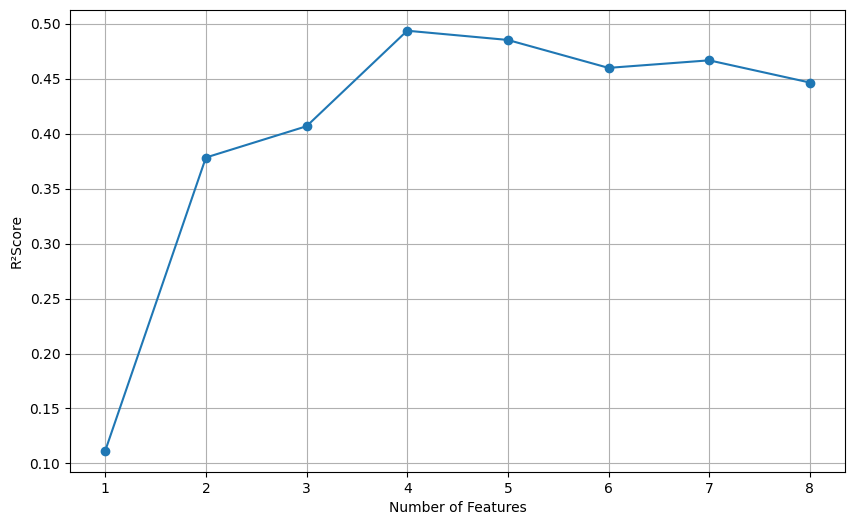

In [ ]:
#특성 선택 단계
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True)
rfecv = RFECV(estimator=xgb_reg, step=1, cv=cv, scoring='r2')
X_selected = rfecv.fit_transform(X_train, y_train)

# 최적의 R² 점수
best_r2 = max(rfecv.cv_results_['mean_test_score'])
print(f"최적 특성 개수: {rfecv.n_features_}")
print(f"최적 특성 조합의 R² 점수: {best_r2}")

feature_names = np.array(X_train.columns)
selected_feature_indices = np.where(rfecv.support_ == True)[0]
selected_feature_names = feature_names[selected_feature_indices]
print("최적으로 선택된 특성 이름:", selected_feature_names)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o', linestyle='-')

plt.xlabel("Number of Features")
plt.ylabel("R²Score")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# XGBoost 모델 객체
xgb_reg = xgb.XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 공간 정의
param_grid = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 9, 12],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Grid Search 적용
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='r2',
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print("Best parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


KeyboardInterrupt: 

XGBoost R² Score: 0.7147
0.2741857043334416


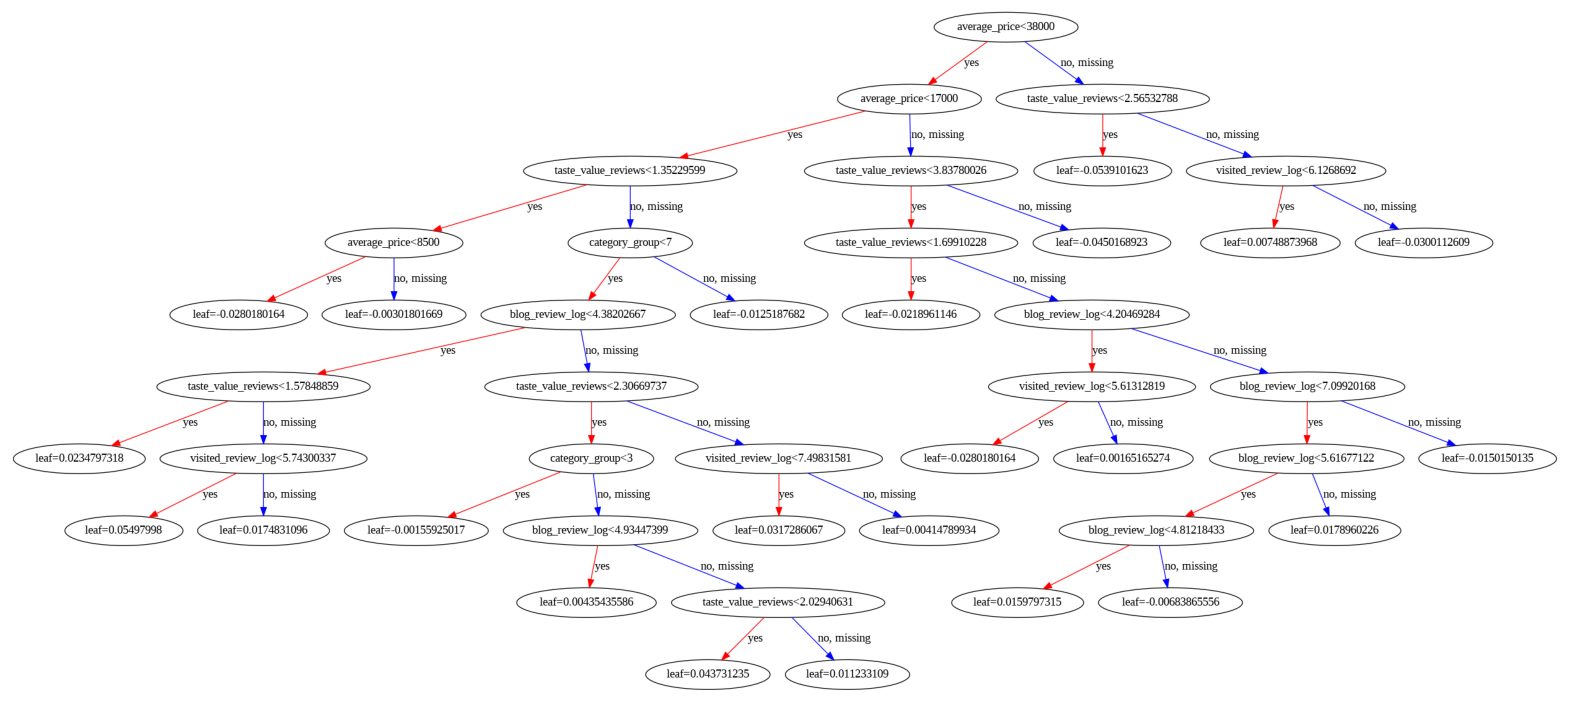

In [ ]:
#하이퍼파라미터 튜닝을 통해 얻은 최적의 모델 (약간의 수정이 추가되어 위의 그리드 서치 결과와 상이할 수 있음)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_reg = xgb.XGBRegressor(
    colsample_bytree=0.7,
    gamma=0.49,
    learning_rate=0.05,
    max_depth=10,
    n_estimators=600,
    subsample=0.7,
    random_state=42
)
xgb_reg.fit(X_train, y_train)

# 예측
y_pred = xgb_reg.predict(X_test)

# 성능 평가
r2 = r2_score(y_test, y_pred)
print(f"XGBoost R² Score: {r2:.4f}")
print(mean_absolute_error(y_test,y_pred))
#print(mean_squared_error(y_test,y_pred))

output = xgb_reg.predict(X)
X_new = X_check.copy()
X_new = pd.merge(X_new,pd.DataFrame(output,columns=['y_pred']),left_index=True,right_index=True)
X_new = X_new[['store_name','rating','distance','category','visited_review','blog_review','menu_listed','average_price','taste_value','y_pred']]

# 트리 시각화 (0번째 트리)
fig, ax = plt.subplots(figsize=(20, 10))
xgb.plot_tree(xgb_reg, num_trees=0, ax=ax)
plt.show()


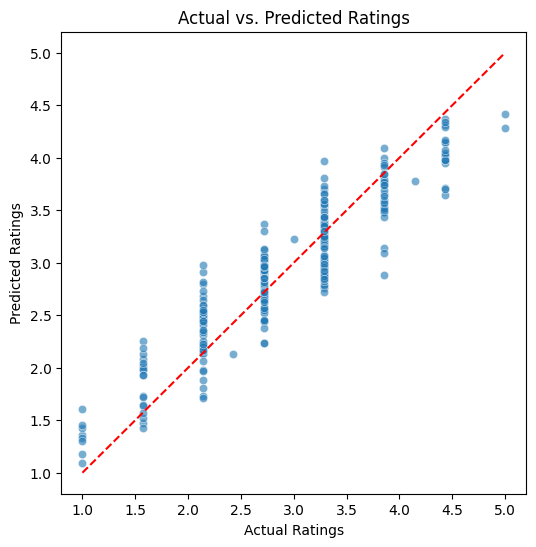

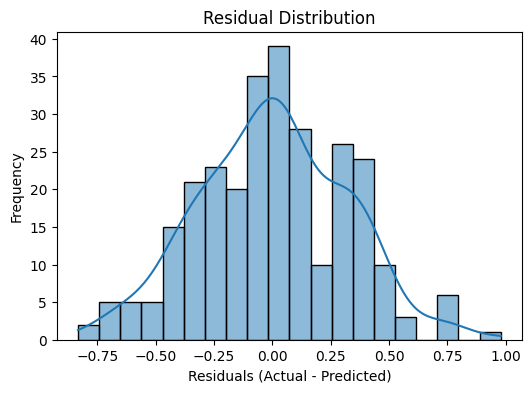

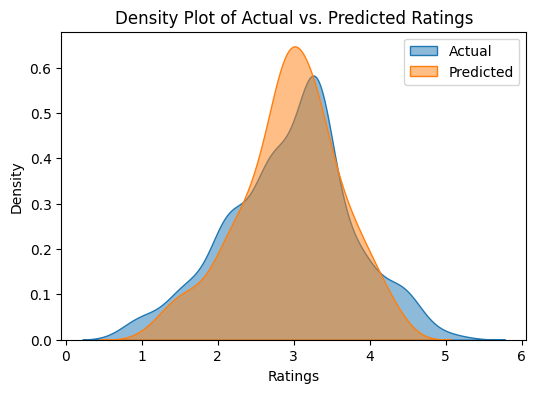

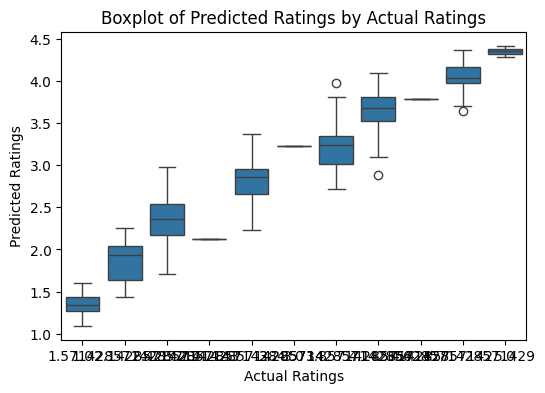

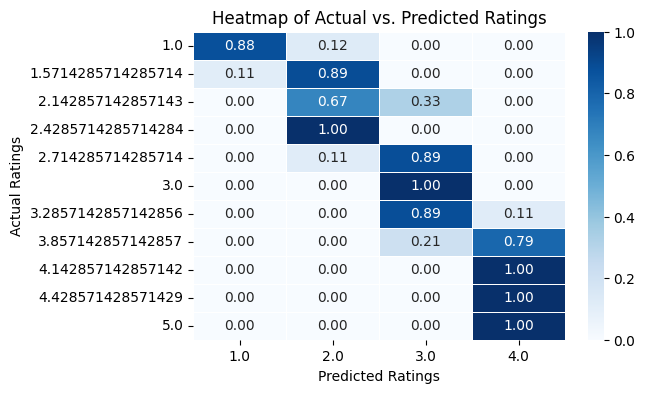

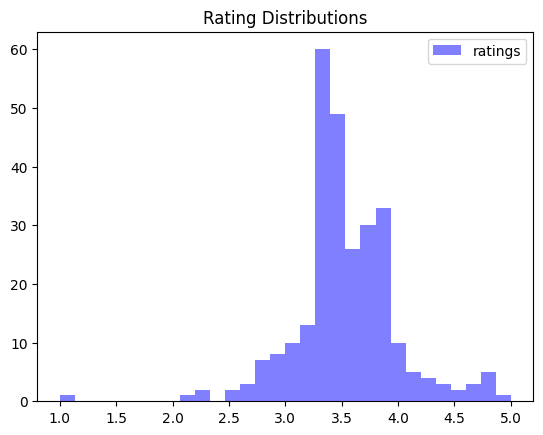

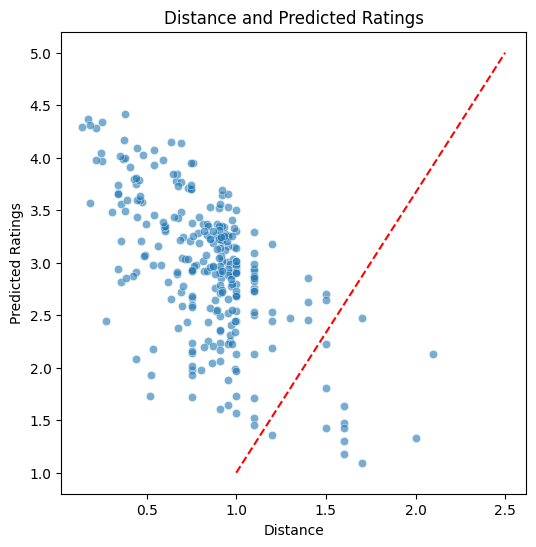

In [ ]:
# 각종 시각화 자료 생
import seaborn as sns
import matplotlib.pyplot as plt
actual_ratings = X_check['y'].to_numpy()

# 1. 산점도 (Scatter Plot)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=actual_ratings, y=output, alpha=0.6)
plt.plot([1, 5], [1, 5], color='red', linestyle='dashed')  # y = x 선
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs. Predicted Ratings")
plt.show()

# 2. 잔차 히스토그램 (Residual Histogram)
residuals = actual_ratings - output
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=20, kde=True)
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

# 3. KDE 플롯 (실제값 vs. 예측값의 밀도)
plt.figure(figsize=(6, 4))
sns.kdeplot(actual_ratings, label="Actual", fill=True, alpha=0.5)
sns.kdeplot(output, label="Predicted", fill=True, alpha=0.5)
plt.xlabel("Ratings")
plt.ylabel("Density")
plt.title("Density Plot of Actual vs. Predicted Ratings")
plt.legend()
plt.show()

# 4. 박스플롯 (Box Plot)
data = pd.DataFrame({"Actual": actual_ratings, "Predicted": output})
plt.figure(figsize=(6, 4))
sns.boxplot(x="Actual", y="Predicted", data=data)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Boxplot of Predicted Ratings by Actual Ratings")
plt.show()

# 5. 히트맵 (Heatmap of Predictions)
conf_matrix = pd.crosstab(actual_ratings, np.round(output), normalize="index")
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.xlabel("Predicted Ratings")
plt.ylabel("Actual Ratings")
plt.title("Heatmap of Actual vs. Predicted Ratings")
plt.show()

rating = X_check['rating'].to_numpy()
# 1. 산점도 (Scatter Plot)
plt.hist(rating,bins=30,alpha=0.5,label = 'ratings',color = 'blue')
#plt.hist(output,bins=30,alpha=0.5,label = 'predict',color='red')
plt.legend()
plt.title("Rating Distributions")
plt.show()

distance = X_check['distance'].to_numpy()
# 1. 산점도 (Scatter Plot)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=distance, y=output, alpha=0.6)
plt.plot([1, 2.5], [1, 5], color='red', linestyle='dashed')  # y = x 선
plt.xlabel("Distance")
plt.ylabel("Predicted Ratings")
plt.title("Distance and Predicted Ratings")
plt.show()
